Imports

In [91]:
import os

import matplotlib.pyplot as plt
import numpy as np
import json
from skmultilearn.model_selection import iterative_train_test_split
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from PIL import Image
import seaborn as sns

import torch
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights
from torchvision.transforms import RandomHorizontalFlip, RandomRotation


Train-Test-Val Split

In [51]:
dataset_directory = "../Dataset Generation/dataset"

# Image and label directory arrays
images = []
labels = []

for recipe_folder in os.listdir(dataset_directory):
    recipe_path = os.path.join(dataset_directory, recipe_folder)
    allergens_file = os.path.join(recipe_path, 'allergens.json')

    if os.path.isfile(allergens_file):
        with open(allergens_file, 'r') as f:
            data = json.load(f)
            allergens = data['allergens']

            for image in data['images']:
                images.append(os.path.join(dataset_directory, recipe_folder, image))
                labels.append(allergens)

In [52]:
x = np.array(images).reshape(-1,1) # iterative_train_test_split expects 2d array
y = np.array(labels)

In [53]:
zeros_per_label = np.sum(y == 0, axis=0).tolist()
ones_per_label = np.sum(y == 1, axis=0).tolist()
print("Number of 0s for each label:")
print(zeros_per_label)
print("Number of 1s for each label")
print(ones_per_label)

Number of 0s for each label:
[37537, 59608, 43784, 53457, 59788, 57758, 23821, 57318, 58289, 57759, 60160, 62022, 62022, 61147]
Number of 1s for each label
[24485, 2414, 18238, 8565, 2234, 4264, 38201, 4704, 3733, 4263, 1862, 0, 0, 875]


In [54]:
x_train, y_train, x_temp, y_temp = iterative_train_test_split(x, y, test_size=0.3) # http://scikit.ml/stratification.html

In [55]:
x_test, y_test, x_val, y_val = iterative_train_test_split(x_temp, y_temp, test_size=0.5)

In [56]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape)

(43415, 1) (43415, 14) (9303, 1) (9303, 14) (9304, 1) (9304, 14)


In [57]:
x_train, y_train, x_test, y_test, x_val, y_val

(array([['../Dataset Generation/dataset\\$25_pumpkin_pie\\images/image_2.jpg'],
        ["../Dataset Generation/dataset\\'get_up_&_go'_bars\\images/image_2.jpg"],
        ['../Dataset Generation/dataset\\(panera_bread)_black_bean_soup\\images/image_2.jpg'],
        ...,
        ["../Dataset Generation/dataset\\zurie's_overnight_no-knead_bread\\images/image_3.jpg"],
        ["../Dataset Generation/dataset\\zurie's_overnight_no-knead_bread\\images/image_4.jpg"],
        ["../Dataset Generation/dataset\\zurie's_overnight_no-knead_bread\\images/image_5.jpg"]],
       dtype='<U115'),
 array([[0, 0, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]]),
 array([['../Dataset Generation/dataset\\$25_pumpkin_pie\\images/image_3.jpg'],
        ["../Dataset Generation/dataset\\'get_up_&_go'_bars\\images/image_1.jpg"],
        ["../Dataset Generation/datase

In [58]:
zeros_per_label = np.sum(y_train == 0, axis=0).tolist()
ones_per_label = np.sum(y_train == 1, axis=0).tolist()
print("Number of 0s for each label:")
print(zeros_per_label)
print("Number of 1s for each label")
print(ones_per_label)

Number of 0s for each label:
[26276, 41725, 30648, 37420, 41851, 40430, 16674, 40122, 40802, 40431, 42112, 43415, 43415, 42803]
Number of 1s for each label
[17139, 1690, 12767, 5995, 1564, 2985, 26741, 3293, 2613, 2984, 1303, 0, 0, 612]


In [59]:
zeros_per_label = np.sum(y_test == 0, axis=0).tolist()
ones_per_label = np.sum(y_test == 1, axis=0).tolist()
print("Number of 0s for each label:")
print(zeros_per_label)
print("Number of 1s for each label")
print(ones_per_label)

Number of 0s for each label:
[5630, 8941, 6568, 8018, 8968, 8663, 3573, 8597, 8743, 8663, 9024, 9303, 9303, 9166]
Number of 1s for each label
[3673, 362, 2735, 1285, 335, 640, 5730, 706, 560, 640, 279, 0, 0, 137]


In [60]:
zeros_per_label = np.sum(y_val == 0, axis=0).tolist()
ones_per_label = np.sum(y_val == 1, axis=0).tolist()
print("Number of 0s for each label:")
print(zeros_per_label)
print("Number of 1s for each label")
print(ones_per_label)

Number of 0s for each label:
[5631, 8942, 6568, 8019, 8969, 8665, 3574, 8599, 8744, 8665, 9024, 9304, 9304, 9178]
Number of 1s for each label
[3673, 362, 2736, 1285, 335, 639, 5730, 705, 560, 639, 280, 0, 0, 126]


Hyperparameters

In [61]:
# Parameters
learning_rate = 1e-5
batch_size = 64
epochs = 200
prediction_threshold = 0.5

Dataset Loader

In [62]:
# Dataset loader class shell: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

class FoodAllergenDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx][0]
        image = Image.open(img_path).convert('RGB') # Convert all images to 3 channel RGB as dataset contains some 4 channel RGBA images
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [63]:
# Transform images to tensors and resize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Test more transforms later in training to improve accuracy - cropping, rotation, centering, flipping etc.

In [64]:
train_dataset = FoodAllergenDataset(x_train, y_train, transform=transform)
val_dataset = FoodAllergenDataset(x_val, y_val, transform=transform)
test_dataset = FoodAllergenDataset(x_test, y_test, transform=transform)

In [65]:
# Create Train Test Val DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Set Accelerator Device

In [66]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


CNN Model Architecture

In [67]:
# Sample CNN model from pytorch
class Net(nn.Module):
    def __init__(self, num_labels=14):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_labels)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [68]:
resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
resnet.fc = nn.Linear(resnet.fc.in_features, 14) # Add final fully connected layer with 14 outputs

In [69]:
#model = Net().to(device)
model = resnet.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Loss Function and Optimizer

In [71]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Training Loop

In [72]:
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0.0

    for batch, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        prediction = model(images)
        loss = loss_fn(prediction, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # Accumulate loss for this batch
        total_loss += loss.item()

        if batch % 100 == 0:
            current = batch * len(images)
            print(f"loss: {loss.item():.7f} [{current:5d}/{size:5d}]")

    # Return average training loss for this epoch
    return total_loss / len(dataloader)

In [73]:
def validate_one_epoch(dataloader, model, loss_fn):
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            prediction = model(images)
            loss = loss_fn(prediction, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(dataloader)
    print(f"Validation loss: {avg_val_loss:.7f}")

    # Return average validation loss for this epoch
    return avg_val_loss

In [74]:
"""
https://www.geeksforgeeks.org/how-to-handle-overfitting-in-pytorch-models-using-early-stopping/

patience: Number of epochs to wait before stopping if no improvement.
delta: Minimum change in the monitored quantity to qualify as an improvement.
best_score, best_model_state: Track the best validation score and model state.
call method: Updates the early stopping logic.
"""

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

In [75]:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
def save_model(epoch, model, optimizer, training_losses, validation_losses):
    torch.save({
        "epoch": epoch+1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "training_losses": training_losses, # full loss history, so that post-checkpoint models will have correct loss graph
        "validation_losses": validation_losses
    }, "model.pt")

In [76]:
# Store losses to be graphed
training_losses = []
validation_losses = []
starting_epoch = 0

In [77]:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
# Only run if loading from checkpoint
def load_model(model_path, model, optimizer):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    checkpoint_epoch = checkpoint["epoch"]
    training_losses = checkpoint["training_losses"]
    validation_losses = checkpoint["validation_losses"]

    return model, optimizer, checkpoint_epoch, training_losses, validation_losses

In [78]:
# # Run if continuing training from a checkpoint
# model, optimizer, starting_epoch, training_losses, validation_losses = load_model("model.pt", model, optimizer)

In [79]:
# Run training and validation loops
best_val_loss = 1_000_000.
early_stopping = EarlyStopping(patience=5, delta=0.05)

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Train and validate this epoch
    train_loss = train_one_epoch(train_dataloader, model, loss_fn, optimizer)
    val_loss = validate_one_epoch(val_dataloader, model, loss_fn)

    # Append losses for this epoch
    training_losses.append(train_loss)
    validation_losses.append(val_loss)

    # Save model checkpoint if validation loss improves
    if val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.7f} to {val_loss:.7f}")
        best_val_loss = val_loss
        save_model(epoch, model, optimizer, training_losses, validation_losses)

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
print(f"Training Complete")

Epoch 1/200
loss: 1.0079440 [    0/43415]
loss: 0.9016706 [ 6400/43415]
loss: 0.9122053 [12800/43415]
loss: 0.7670298 [19200/43415]
loss: 0.7283399 [25600/43415]


C:\GitHub\FYP\.venv\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


loss: 0.7275975 [32000/43415]
loss: 0.6688393 [38400/43415]
Validation loss: 0.7278958
Validation loss improved from 1000000.0000000 to 0.7278958
Epoch 2/200
loss: 0.7299228 [    0/43415]
loss: 0.7659057 [ 6400/43415]
loss: 0.6345850 [12800/43415]
loss: 0.6796437 [19200/43415]
loss: 0.7770025 [25600/43415]
loss: 0.7036387 [32000/43415]
loss: 0.7054083 [38400/43415]
Validation loss: 0.6849876
Validation loss improved from 0.7278958 to 0.6849876
Epoch 3/200
loss: 0.6347642 [    0/43415]
loss: 0.6511953 [ 6400/43415]
loss: 0.5881621 [12800/43415]
loss: 0.6015446 [19200/43415]
loss: 0.6358356 [25600/43415]
loss: 0.6173746 [32000/43415]
loss: 0.5465981 [38400/43415]
Validation loss: 0.6627845
Validation loss improved from 0.6849876 to 0.6627845
Epoch 4/200
loss: 0.5376888 [    0/43415]
loss: 0.5264932 [ 6400/43415]
loss: 0.5323693 [12800/43415]
loss: 0.5691973 [19200/43415]
loss: 0.5644903 [25600/43415]
loss: 0.5320353 [32000/43415]
loss: 0.5166013 [38400/43415]
Validation loss: 0.6562461
V

Model Evaluation

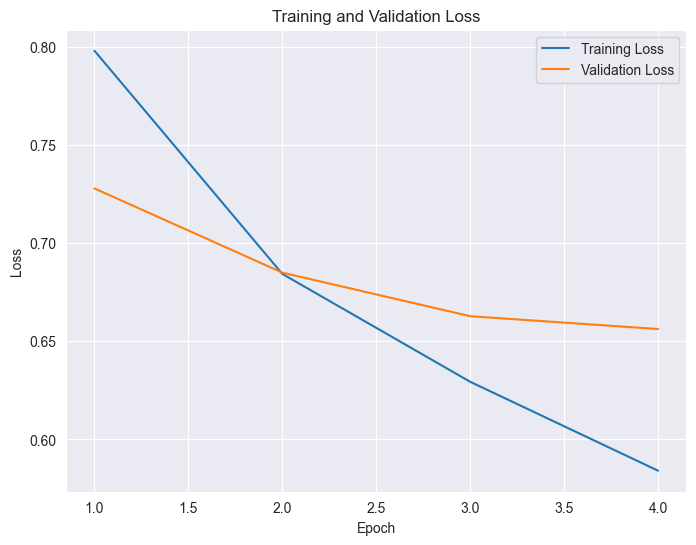

In [86]:
# load losses and epochs from saved model
model, optimizer, epochs, training_losses, validation_losses = load_model("model.pt", model, optimizer)

# Plot losses
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
model.eval()

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        outputLogits = model(images)
        outputs = torch.sigmoid(outputLogits)
        print(outputs)

tensor([[8.4652e-01, 1.2029e-04, 9.7412e-01, 4.1816e-04, 3.7830e-04, 9.6686e-04,
         9.7982e-01, 2.3085e-01, 2.2113e-05, 2.5922e-06, 4.6609e-04, 2.8651e-06,
         3.7819e-06, 5.7089e-04],
        [2.5644e-01, 4.7130e-03, 9.9843e-01, 9.6316e-03, 1.4837e-04, 5.9396e-06,
         7.8187e-01, 1.3047e-03, 3.3765e-03, 3.5851e-02, 9.7096e-05, 1.8943e-06,
         1.7083e-06, 2.1768e-04],
        [2.2941e-01, 1.0808e-02, 8.9679e-02, 9.0248e-05, 5.8281e-03, 3.3219e-01,
         8.3415e-01, 1.7405e-04, 2.2676e-02, 4.6512e-03, 3.5930e-03, 9.5557e-06,
         1.4592e-05, 6.7042e-02],
        [2.3862e-01, 2.1211e-03, 2.1810e-03, 1.3989e-02, 4.2936e-03, 9.3822e-01,
         3.5942e-01, 2.0523e-04, 9.9994e-01, 1.2271e-03, 1.3696e-02, 1.7206e-06,
         1.2342e-06, 1.3846e-03],
        [1.3693e-01, 1.0894e-03, 3.1957e-02, 1.0317e-01, 1.5576e-03, 8.5217e-03,
         4.3842e-01, 2.2512e-01, 1.1870e-02, 2.0080e-03, 3.0700e-02, 7.8245e-05,
         6.6019e-05, 2.7498e-02],
        [8.1161e-01,

KeyboardInterrupt: 

In [87]:
ALLERGENS = [
    "Cereals containing gluten", "Crustaceans", "Eggs", "Fish",
    "Peanuts", "Soybeans", "Milk", "Nuts", "Celery", "Mustard",
    "Sesame seeds",  "Sulphur dioxide and sulphites", "Lupin", "Molluscs"
]

In [88]:
def plot_confusion_matrices(matrices):
    # Plot matrices on seaborn
    for i, matrix in enumerate(matrices):
        plt.figure(figsize=(4, 3))
        sns.heatmap(
            matrix,
            annot=True,
            fmt="d",
            cmap="Reds",
            cbar=False,
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"]
        )
        plt.title(f"Confusion Matrix: {ALLERGENS[i]}")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.tight_layout()
        plt.show()

In [96]:
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

def test_loop(dataloader, model):
    model.eval()
    total, correct = 0, 0
    all_predictions = []
    all_actual = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputLogits = model(images)
            probs = torch.sigmoid(outputLogits) # # Apply sigmoid to convert logits to get probabilities 0-1
            preds = (probs > prediction_threshold).long() # Get binary predictions based on prediction threshold param

            total += labels.numel()
            correct += (preds == labels).sum().item()

            all_predictions.append(preds.cpu().numpy())
            all_actual.append(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Test Error: \n Accuracy: {accuracy:.2f} % \n\n')

    all_predictions = np.concatenate(all_predictions, axis=0)
    all_actual = np.concatenate(all_actual, axis=0)

    matrices = multilabel_confusion_matrix(all_actual, all_predictions)
    plot_confusion_matrices(matrices)

    print("Classification Report:")
    # Sklearn classification report
    report = classification_report(all_actual, all_predictions, target_names=ALLERGENS, zero_division=0)
    print(report)

Test Error: 
 Accuracy: 83.29 % 




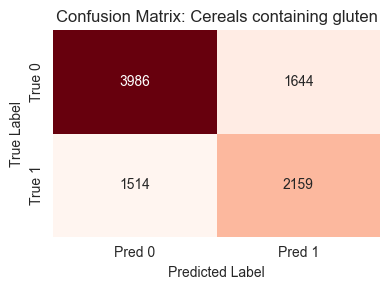

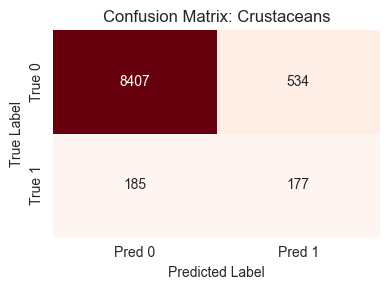

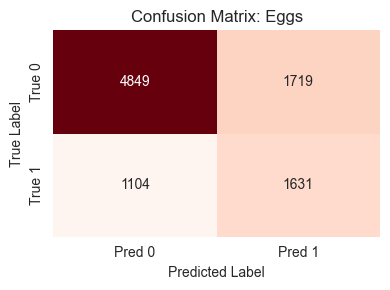

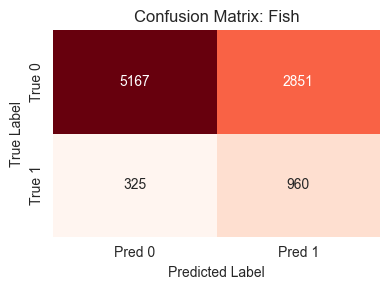

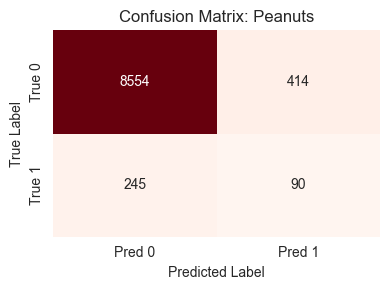

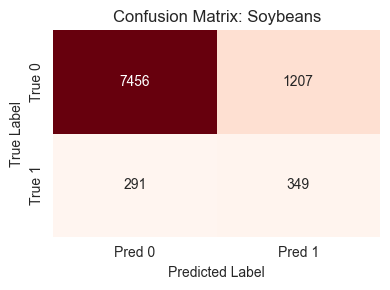

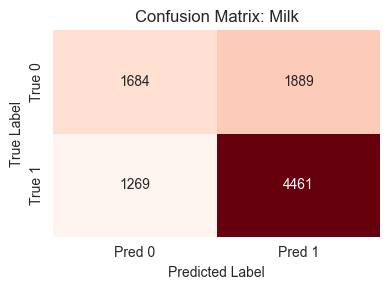

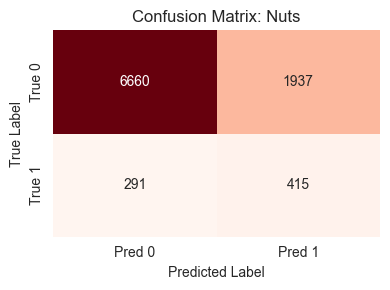

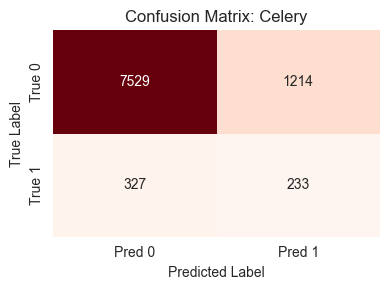

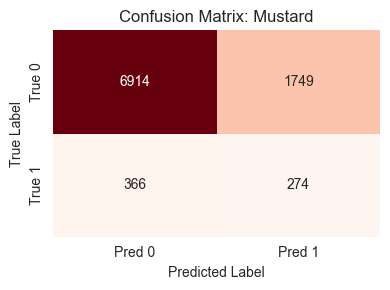

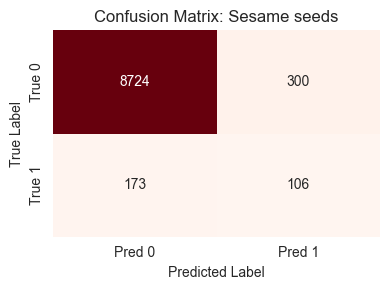

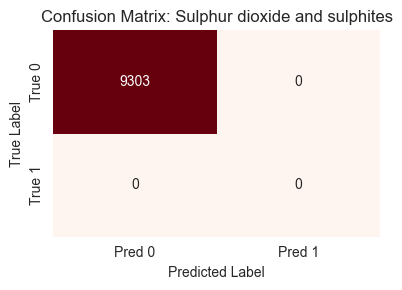

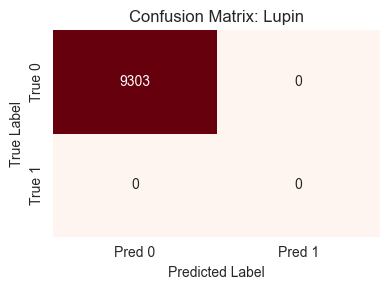

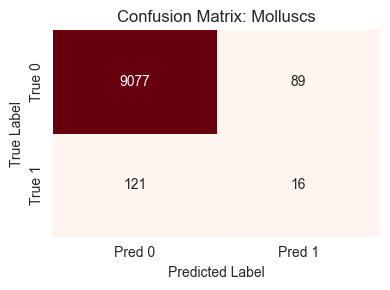

Classification Report:
                               precision    recall  f1-score   support

    Cereals containing gluten       0.57      0.59      0.58      3673
                  Crustaceans       0.25      0.49      0.33       362
                         Eggs       0.49      0.60      0.54      2735
                         Fish       0.25      0.75      0.38      1285
                      Peanuts       0.18      0.27      0.21       335
                     Soybeans       0.22      0.55      0.32       640
                         Milk       0.70      0.78      0.74      5730
                         Nuts       0.18      0.59      0.27       706
                       Celery       0.16      0.42      0.23       560
                      Mustard       0.14      0.43      0.21       640
                 Sesame seeds       0.26      0.38      0.31       279
Sulphur dioxide and sulphites       0.00      0.00      0.00         0
                        Lupin       0.00      0.00   

In [97]:
test_loop(test_dataloader, model)